## Labeling Grocery Store Items with a CNN

The dataset contains natural images of grocery items. All natural images were taken with a smartphone camera in different grocery stores. Total 5125 natural images from 81 different classes of fruits, vegetables, and carton items (e.g. juice, milk, yoghurt). The 81 classes are divided into 42 coarse-grained classes, where e.g. the fine-grained classes 'Royal Gala' and 'Granny Smith' belong to the same coarse-grained class 'Apple'. For each fine-grained class, downloaded an iconic image and a product description of the item, where some samples of these can be seen on this page below. The dataset was presented in the paper "A Hierarchical Grocery Store Image Dataset with Visual and Semantic Labels", which appeared at WACV 2019.

In [83]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
import os
import random
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns

### Data Preprocessing / Preparation

##### Check to see if the Data, i.e. the images are looking the way they should

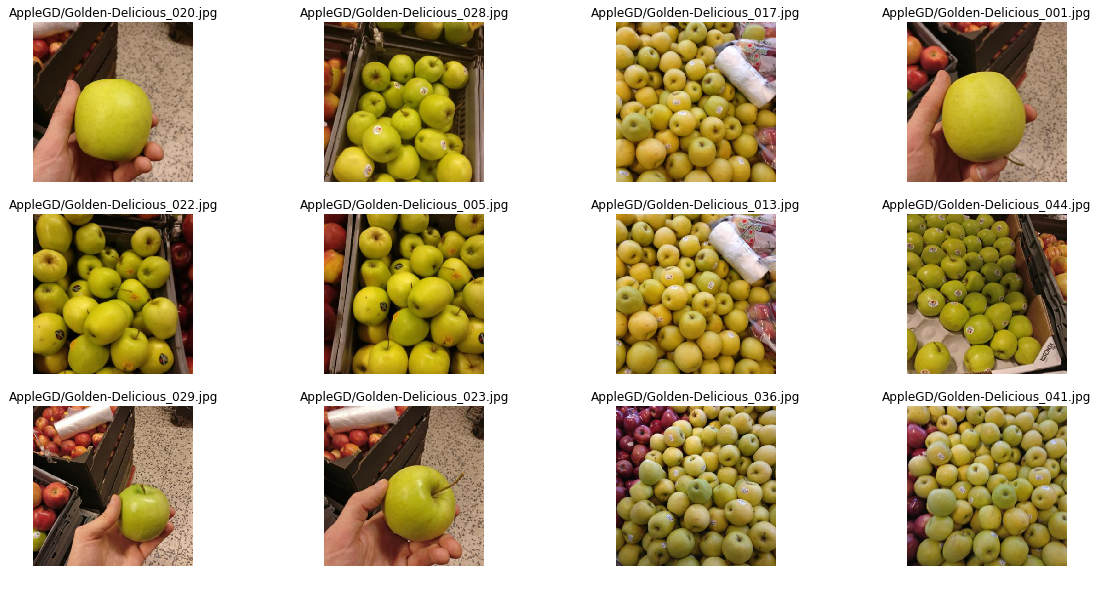

In [13]:
# Getting the list of file names
_, _, fruit_images = next(os.walk('GroceryStoreDataset/dataset/train/Fruit/Apple/Golden-Delicious'))

# Preparing the grid
fig, ax = plt.subplots(3, 4, figsize = (20, 10))

# Images will be selected and plotted using matplotlib
for i, img in enumerate(random.sample(fruit_images, 12)):
    img_read = plt.imread('GroceryStoreDataset/dataset/train/Fruit/Apple/Golden-Delicious/' + img)
    ax[int(i/4), i%4].imshow(img_read)
    ax[int(i/4), i%4].axis('off')
    ax[int(i/4), i%4].set_title('AppleGD/' + img)
    
plt.show()

The labels provided by the dataset from Kaggle need to be imported -> This is in the csv file: classes.csv (grocery_store\GroceryStoreDataset\dataset)

In [17]:
# Assigning the labels to a dataframe using Pandas
label_df = pd.read_csv('GroceryStoreDataset/dataset/classes.csv')

In [55]:
# Assigning the train, test, and validation directories
train_dir = 'GroceryStoreDataset/dataset/train'
validation_dir = 'GroceryStoreDataset/dataset/val'
test_dir = 'GroceryStoreDataset/dataset/test'


#### Image Augmentation:
Creation of additional training and validation data.

In [21]:
# Creating an ImageDataGenerator object with data augmentation
datagen = ImageDataGenerator(
    rotation_range = 30,
    width_shift_range = 0.2,
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True)

IMG_SIZE = (348, 348)
BATCH_SIZE = 32

In [56]:
# Using the flow_from_directory method to load the images
# Creating the train generator
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical')

Found 2640 images belonging to 3 classes.


In [57]:
# Creating the validation generator
validation_generator =  datagen.flow_from_directory(
    validation_dir,
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical')

Found 296 images belonging to 3 classes.


In [58]:
# Creating the testing generator
testing_generator = datagen.flow_from_directory(
    test_dir,
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical')

Found 2485 images belonging to 3 classes.


Checking to see how much data we have per each class -> Should be as even as possible!

In [129]:
def count_images(path):
    count = 0
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.png'):
                count += 1
    return count

fruit_dir = 'GroceryStoreDataset/dataset/train/Fruit'
pack_dir = 'GroceryStoreDataset/dataset/train/Packages'
veg_dir = 'GroceryStoreDataset/dataset/train/Vegetables'

list_of_dir = [fruit_dir, pack_dir, veg_dir]

for directory in list_of_dir:
    num_images = count_images(directory)
    print(f'There are {num_images} images in {directory} and its subfolders.')

There are 1142 images in GroceryStoreDataset/dataset/train/Fruit and its subfolders.
There are 864 images in GroceryStoreDataset/dataset/train/Packages and its subfolders.
There are 634 images in GroceryStoreDataset/dataset/train/Vegetables and its subfolders.


### Model Building -> Building the CNN

In [59]:
model_new = Sequential()


#### First Convolution Layer (1/3):

In [60]:
model_new.add(Conv2D(32, (3, 3), activation = 'relu', 
                input_shape = (348, 348, 3)))

In [61]:
# Max Pooling Layer to go with Conv Layer
model_new.add(MaxPooling2D((2, 2)))

#### Second Convolution Layer (2/3):

In [62]:
model_new.add(Conv2D(64, (3, 3), activation = 'relu',
                input_shape = (348, 348, 3)))

In [63]:
model_new.add(MaxPooling2D((2, 2)))

#### Third Convolution Layer (3/3):

In [64]:
model_new.add(Conv2D(128, (3, 3), activation = 'relu',
                input_shape = (348, 348, 3)))

In [65]:
model_new.add(MaxPooling2D((2, 2)))

#### Flatten Layer:

In [66]:
model_new.add(Flatten())

#### First Fully Connected Layer (1/2):

In [67]:
model_new.add(Dense(128, activation = 'relu'))

#### Second Fully Connected Layer(2/2):

In [68]:
model_new.add(Dense(3, activation = 'softmax'))

In [114]:
model_new.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 346, 346, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 173, 173, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 171, 171, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 85, 85, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 83, 83, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 41, 41, 128)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 215168)            0         
__________

### Compiling the Model:

In [71]:
model_new.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

### Fitting the Model:

In [72]:
model_new.fit_generator(train_generator,
         steps_per_epoch = train_generator.samples // BATCH_SIZE,
         validation_data = validation_generator,
         validation_steps = validation_generator.samples // BATCH_SIZE,
         epochs = 10)

Epoch 1/10
82/82 [==============================] - 345s 4s/step - loss: 1.0547 - acc: 0.6246 - val_loss: 0.9183 - val_acc: 0.6212
Epoch 2/10
82/82 [==============================] - 320s 4s/step - loss: 0.6061 - acc: 0.7332 - val_loss: 1.0372 - val_acc: 0.5871
Epoch 3/10
82/82 [==============================] - 321s 4s/step - loss: 0.5789 - acc: 0.7504 - val_loss: 0.9815 - val_acc: 0.6285
Epoch 4/10
82/82 [==============================] - 318s 4s/step - loss: 0.5161 - acc: 0.7889 - val_loss: 0.8457 - val_acc: 0.6023
Epoch 5/10
82/82 [==============================] - 319s 4s/step - loss: 0.4787 - acc: 0.7973 - val_loss: 0.8965 - val_acc: 0.6553
Epoch 6/10
82/82 [==============================] - 319s 4s/step - loss: 0.4410 - acc: 0.8125 - val_loss: 0.9548 - val_acc: 0.6402
Epoch 7/10
82/82 [==============================] - 317s 4s/step - loss: 0.4477 - acc: 0.8095 - val_loss: 0.8452 - val_acc: 0.6705
Epoch 8/10
82/82 [==============================] - 317s 4s/step - loss: 0.4286 - a

### Evaluating the Model:

1. Estimating Accuracy and Loss Scores

In [73]:
score = model_new.evaluate_generator(testing_generator, len(testing_generator))

for i, metric in enumerate(model.metrics_names):
    print('{}: {}'.format(metric, score[i]))

loss: 0.4889875187960189
acc: 0.8120724347755462


2. Analysing Predictions generating **Precision,** **Recall,** and **F1** Scores.

In [115]:
# Generate predictions on the test data
predictions = model_new.predict_generator(testing_generator, steps = 2485 / BATCH_SIZE)

#Convert the predictions to class labels
predicted_classes = np.argmax(predictions, axis = 1)

# Convert the test labels to class labels
true_classes = testing_generator.classes


# Compute precision, recall, and F1 Score
precision = precision_score(true_classes, predicted_classes, average = 'weighted')
recall = recall_score(true_classes, predicted_classes, average = 'weighted')
f1 = f1_score(true_classes, predicted_classes, average = 'weighted')

print('Precision:', precision )
print('Recall Score:', recall)
print('F1 Score', f1)

Precision: 0.342703582485284
Recall Score: 0.36016096579476864
F1 Score 0.34687816212524225


In [122]:
# assume y_true and y_pred are the ground truth labels and predicted labels, respectively
precision_fruits = precision_score(true_classes, predicted_classes, labels=[0], average="macro")
precision_packages = precision_score(true_classes, predicted_classes, labels=[1], average="macro")
precision_vegetables = precision_score(true_classes, predicted_classes, labels=[2], average="macro")

print("Precision for Fruits:", precision_fruits)
print("Precision for Packages:", precision_packages)
print("Precision for Vegetables:", precision_vegetables)

Precision for Fruits: 0.4379391100702576
Precision for Packages: 0.2990867579908676
Precision for Vegetables: 0.21951219512195122


3. Generating the Confusion matrix and visualising using Seaborn

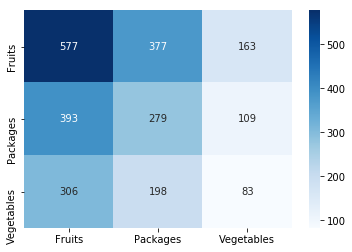

In [123]:
# Get the number of samples in the test data generator
num_samples = len(testing_generator)

# Get the actual labels from the test data generator
y_true = []
for i in range(num_samples):
    _, labels = testing_generator[i]
    y_true.extend(np.argmax(labels, axis=1))  # Convert one-hot encoded labels to integers

# Get the predicted labels from your model
y_pred = model_new.predict_generator(testing_generator, steps=num_samples)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, np.argmax(y_pred, axis=1))

# Writing out the label names so it's easier to understand
label_names = ['Fruits', 'Packages', 'Vegetables']

# Create a heatmap of the confusion matrix using seaborn
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=label_names, yticklabels=label_names)
    

4. Producing a function that takes an image and outputs a classification label using the model.

### Summary:

It would seem our CNN model produced above is not performing very well especially when it comes to precision. 
An overall accuracy score of 0.81 is respectable but does not give us enough information about how the model truly performs when it comes to understanding i.e. identifying each of the three class labels.  

The model seems to be especially bad at classifying Vegetables. A potential reason is the fact that there are simply not enough Vegetables in the dataset for it to have understood quickly enough the distinctiveness of vegetables especially when compared to fruits as it would seem most of the false labeling has to do with the model understanding vegetables to be fruit. 

The same can be said for packages, however, it seemed to have got more of these right. This adds weight to the argument that the dataset is not evenly distributed enough which leads to the less than spectacular results.

Possible solutions include either gathering more data so that the class labels are more evenly distributed and / or retuning the hyperparameters of the model and perhaps adding a few more Convolutional Layers to it. 